In [ ]:
#updated........................

In [ ]:
#-----------------  without using ibuilt dct ------------------------#####-------------------

Enter the block size: 8
Enter the quality factor: 0.75
Enter the shift vector threshold: 10
Enter the sliding window stride: 1


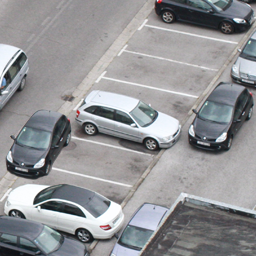

Input Image: Original Image


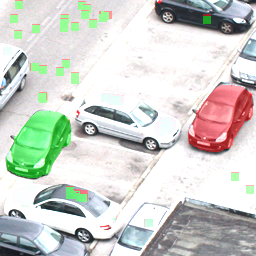

Output Image: Forged regions marked in red, Original regions marked in green


In [ ]:
import numpy as np
import cv2
from operator import itemgetter
from google.colab.patches import cv2_imshow

class QuantizationMatrix():
    Q50 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    Q75 = np.array([[8, 6, 5, 8, 12, 20, 26, 31],
                    [6, 6, 7, 10, 13, 29, 30, 28],
                    [7, 7, 8, 12, 20, 29, 35, 28],
                    [7, 9, 11, 15, 26, 44, 40, 31],
                    [9, 1, 19, 28, 34, 55, 52, 39],
                    [12, 18, 28, 32, 41, 52, 57, 46],
                    [25, 32, 39, 44, 52, 61, 60, 52],
                    [36, 46, 48, 49, 56, 50, 52, 50]])

    Q90 = np.array([[3, 2, 2, 3, 5, 8, 10, 12],
                    [2, 2, 3, 4, 5, 12, 12, 11],
                    [3, 3, 3, 5, 8, 11, 14, 11],
                    [3, 3, 4, 6, 10, 17, 16, 12],
                    [4, 4, 7, 11, 14, 22, 21, 15],
                    [5, 7, 11, 13, 16, 12, 23, 18],
                    [10, 13, 16, 17, 21, 24, 24, 21],
                    [14, 18, 19, 20, 22, 20, 20, 20]])

    Qrand = np.array([[4, 4, 6, 11, 24, 24, 24, 24],
                      [4, 5, 6, 16, 24, 24, 24, 24],
                      [6, 6, 14, 24, 24, 24, 24, 24],
                      [11, 16, 24, 24, 24, 24, 24, 24],
                      [24, 24, 24, 24, 24, 24, 24, 24],
                      [24, 24, 24, 24, 24, 24, 24, 24],
                      [24, 24, 24, 24, 24, 24, 24, 24],
                      [24, 24, 24, 24, 24, 24, 24, 24]])

    def get_qm(self, qf=0.75):
        if qf == 0.5:
            return self.Q50
        elif qf == 0.75:
            return self.Q75
        elif qf == 0:
            return self.Qrand
        elif qf == 0.9:
            return self.Q90


def read_img(img_path):
    # cv2.imread directly to read the image
    original_image = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # To Check if the image is loaded successfully
    if original_image is None:
        raise ValueError(f"Error: Unable to load image from {img_path}")

    # Convert to grayscale
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    overlay = original_image.copy()

    img = np.array(image)
    height, width = img.shape

    return img, original_image, overlay, width, height



def dct(x):
   N = x.shape[0]
   X = np.zeros(x.shape, dtype=np.float64)
   for k in range(N):
       for n in range(N):
           X[k] += x[n] * np.cos((np.pi / N) * (n + 0.5) * k)
       X[k] *= np.sqrt(2 / N)
   return X


def create_quantize_dct(img, width, height, block_size, stride, Q_8x8):
    quant_row_matrices = []

    for i in range(0, height - block_size, stride):
        for j in range(0, width - block_size, stride):
            block = img[i: i + block_size, j: j + block_size]

            # DCT
            dct_matrix = dct_matrix = dct(block)

            # Quantization of DCT coefficients
            quant_block = np.round(np.divide(dct_matrix, Q_8x8))
            block_row = list(quant_block.flatten())

            # Left-corner pixel coordinates and block
            quant_row_matrices.append([(i, j), block_row])

    return quant_row_matrices

def lexographic_sort(quant_row_matrices):
    sorted_blocks = sorted(quant_row_matrices, key=itemgetter(1))

    # FORMAT: [[block1], [block2], (pos1), (pos2), shift vector]
    matched_blocks = []

    # To keep track of shift count
    shift_vec_count = {}

    for i in range(len(sorted_blocks) - 1):
        if sorted_blocks[i][1] == sorted_blocks[i + 1][1]:
            point1 = sorted_blocks[i][0]
            point2 = sorted_blocks[i + 1][0]

            # Shift vector
            s = np.linalg.norm(np.array(point1) - np.array(point2))

            # Increment count for s
            shift_vec_count[s] = shift_vec_count.get(s, 0) + 1
            matched_blocks.append([sorted_blocks[i][1], sorted_blocks[i + 1][1],
                                   point1, point2, s])

    return shift_vec_count, matched_blocks

def shift_vector_thresh(shift_vec_count, matched_blocks, shift_thresh):
    matched_pixels_start = []
    for sf in shift_vec_count:
        if shift_vec_count[sf] > shift_thresh:
            for row in matched_blocks:
                if sf == row[4]:
                    matched_pixels_start.append([row[2], row[3]])

    return matched_pixels_start

def display_results(overlay, original_image, matched_pixels_start, block_size):
    alpha = 0.5
    orig = original_image.copy()

    for starting_points in matched_pixels_start:
        p1 = starting_points[0]
        p2 = starting_points[1]

        overlay[p1[0]: p1[0] + block_size, p1[1]: p1[1] + block_size] = (0, 0, 255)
        overlay[p2[0]: p2[0] + block_size, p2[1]: p2[1] + block_size] = (0, 255, 0)

    cv2.addWeighted(overlay, alpha, original_image, 1, 0, original_image)

    cv2_imshow(orig)
    print("Input Image: Original Image")
    cv2_imshow(original_image)
    print("Output Image: Forged regions marked in red, Original regions marked in green")
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Input image path
img_path = '/content/forged1.png' # Change this to your image path

# User-defined parameters
block_size = int(input("Enter the block size: "))
qf = float(input("Enter the quality factor: "))
shift_thresh = int(input("Enter the shift vector threshold: "))
stride = int(input("Enter the sliding window stride: "))

# 8x8 quantization matrix based on QF
Q_8x8 = QuantizationMatrix().get_qm(qf)

# Read image
img, original_image, overlay, width, height = read_img(img_path)

# DCT
quant_row_matrices = create_quantize_dct(img, width, height, block_size, stride, Q_8x8)

# Lexicographic sort
shift_vec_count, matched_blocks = lexographic_sort(quant_row_matrices)

# Shift vector thresholding
matched_pixels_start = shift_vector_thresh(shift_vec_count, matched_blocks, shift_thresh)

# Displaying output
display_results(overlay, original_image, matched_pixels_start, block_size)